In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Reshape, Concatenate, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [16]:
# Data loading and preprocessing
xie_1 = pd.read_csv(r'well_log.csv', encoding='ANSI')
print(xie_1.columns)

Index(['CNL_Z', 'Density_0108', 'GR_Z', 'P-wave_0108', 'S-wave_0108'], dtype='object')


In [17]:
# Normalization (automatic normalization)
scalers = {}  # Dictionary to store scalers for inverse transformation later
for col in xie_1.columns[:13]:
    scaler = MinMaxScaler()  
    xie_1[col] = scaler.fit_transform(xie_1[col].values.reshape(-1,1))
    scalers[col] = scaler  # Store scaler for later use

In [18]:
# Convert from dataframe to array
xie_1_1 = np.array(xie_1)  # Extract features - xie_1
data = xie_1_1
cnl = data[:,0]   # CNL_Z corresponding to index 1
den = data[:,1]   # Density_0108 corresponding to index 2
gr = data[:,2]    # GR_Z corresponding to index 3
vp = data[:,3]    # P-wave_0108 corresponding to index 7
vs = data[:,4]    # S-wave_0108 corresponding to index 11

vp0 = np.expand_dims(vp, 1)
vs0 = np.expand_dims(vs, 1)
den0 = np.expand_dims(den, 1)
vpvsden = np.concatenate((vp0, vs0, den0), axis=1)
print(vpvsden.shape)

gr0 = np.expand_dims(gr, 1)
cnl0 = np.expand_dims(cnl, 1)
grcnl = np.concatenate((gr0, cnl0), axis=1)
print(grcnl.shape)

(1361, 3)
(1361, 2)


In [19]:
# Create multi-output feature dataset
def create_dataset_multi_output(X, y1, y2, seq_len):
    """
    Create multi-output dataset
    X: input features
    y1: first output (gr)
    y2: second output (cnl)
    seq_len: sequence length
    """
    features = []
    targets_gr = []
    targets_cnl = []
    
    for i in range(0, len(X) - seq_len, 1):  # 1 is the step size
        data = X[i:i+seq_len]  # Sequence data  
        label_gr = y1[i+seq_len//2]  # gr label data
        label_cnl = y2[i+seq_len//2]  # cnl label data
        # Save to features and labels
        features.append(data)
        targets_gr.append(label_gr)
        targets_cnl.append(label_cnl)
    
    # Return
    return np.array(features), np.array(targets_gr), np.array(targets_cnl)  # Return samples and two label

In [20]:
# Sequence length of 11, create new dataset with labels
Len1 = 9
# Modified: use vpvsden as input, gr and cnl as output
(x1, y1_gr, y1_cnl) = create_dataset_multi_output(vpvsden, gr, cnl, Len1)  # Modified: use vpvsden to predict gr and cnl
print(x1.shape, y1_gr.shape, y1_cnl.shape)

x1 = x1.reshape(x1.shape[0], x1.shape[1]*x1.shape[2])
print(x1.shape)

(1352, 9, 3) (1352,) (1352,)
(1352, 27)


In [21]:
# Define multi-output STABGCN model
def build_multi_output_stabgcn_model(input_shape):
    """
    Multi-output STABGCN model for simultaneous GR and CNL prediction
    """
    # Input layer
    inputs = Input(shape=input_shape)
    features = input_shape[0]
    
    # ------- 2D-CNN branch -------
    # Reshape to square image
    side_length = int(np.ceil(np.sqrt(features)))
    padding_needed = side_length * side_length - features
    
    x_padded = tf.pad(inputs, [[0, 0], [0, padding_needed]])
    reshaped_2d = Reshape((side_length, side_length, 1))(x_padded)
    
    # Convolutional layers
    conv2d = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',
                   kernel_regularizer=tf.keras.regularizers.l2(0.001))(reshaped_2d)
    pool = MaxPooling2D(pool_size=(2, 2))(conv2d)
    dropout_cnn = Dropout(0.2)(pool)
    cnn_flat = Flatten()(dropout_cnn)
    
    # ------- BiGRU branch -------
    # Build sequence representation
    seq_length = features // 3  # For vpvsden, each time step has 3 features (vp, vs, den)
    
    # Reshape to sequence
    x_seq = Reshape((seq_length, 3))(inputs[:, :seq_length*3])  # Each time step has 3 features
    
    # BiGRU layer
    bigru = Bidirectional(GRU(32, 
                            recurrent_regularizer=tf.keras.regularizers.l2(0.001),
                            kernel_regularizer=tf.keras.regularizers.l2(0.001)))(x_seq)
    dropout_gru = Dropout(0.2)(bigru)
    
    # Merge features
    merged = Concatenate()([cnn_flat, dropout_gru])
    
    # Shared layers
    shared = Dense(128, activation='relu', 
                  kernel_regularizer=tf.keras.regularizers.l2(0.001))(merged)
    shared_dropout = Dropout(0.2)(shared)
    
    # Branch network - GR prediction
    gr_branch = Dense(64, activation='relu', 
                     kernel_regularizer=tf.keras.regularizers.l2(0.001))(shared_dropout)
    gr_dropout = Dropout(0.2)(gr_branch)
    gr_output = Dense(1, name='gr_output')(gr_dropout)  # GR output
    
    # Branch network - CNL prediction
    cnl_branch = Dense(64, activation='relu', 
                      kernel_regularizer=tf.keras.regularizers.l2(0.001))(shared_dropout)
    cnl_dropout = Dropout(0.2)(cnl_branch)
    cnl_output = Dense(1, name='cnl_output')(cnl_dropout)  # CNL output
    
    # Create model with two outputs
    model = Model(inputs=inputs, outputs=[gr_output, cnl_output])
    
    # Learning rate decay
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=100,
        decay_rate=0.9)
    
    optimizer = Adam(learning_rate=lr_schedule)
    
    # Compile model with MSE loss for both outputs
    model.compile(
        optimizer=optimizer, 
        loss={'gr_output': 'mse', 'cnl_output': 'mse'},
        loss_weights={'gr_output': 1.0, 'cnl_output': 1}  # Equal weights for both outputs
    )
    
    return model


In [22]:
# Define data shape
features = Len1*3  # Input feature dimensions, Len1*3 (because vpvsden has 3 features per time step)
input_shape = (features,)  # Define input shape

# Build model
model3 = build_multi_output_stabgcn_model(input_shape)

# Output model structure
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 27)]                 0         []                            
                                                                                                  
 tf.compat.v1.pad_1 (TFOpLa  (None, 36)                   0         ['input_2[0][0]']             
 mbda)                                                                                            
                                                                                                  
 reshape_2 (Reshape)         (None, 6, 6, 1)              0         ['tf.compat.v1.pad_1[0][0]']  
                                                                                                  
 conv2d_1 (Conv2D)           (None, 6, 6, 32)             320       ['reshape_2[0][0]']     

In [23]:
# Data preparation
source_points = x1
target_points_gr = y1_gr
target_points_cnl = y1_cnl
print(source_points.shape, target_points_gr.shape, target_points_cnl.shape)

# Standardize data
scaler = StandardScaler()
source_points_scaled = scaler.fit_transform(source_points)

(1352, 27) (1352,) (1352,)


In [24]:
# Split data into training and testing sets
X_train, X_test, y_train_gr, y_test_gr, y_train_cnl, y_test_cnl = train_test_split(
    source_points_scaled, target_points_gr, target_points_cnl, test_size=0.15, random_state=42
)
print(X_train.shape, X_test.shape, y_train_gr.shape, y_test_gr.shape, y_train_cnl.shape, y_test_cnl.shape)

# Train model - multi-output
history = model3.fit(
    X_train, 
    {'gr_output': y_train_gr, 'cnl_output': y_train_cnl}, 
    epochs=150, 
    batch_size=100, 
    validation_split=0.05, 
    verbose=1
)

# Evaluate model - multi-output
eval_results = model3.evaluate(
    X_test, 
    {'gr_output': y_test_gr, 'cnl_output': y_test_cnl},
    verbose=1
)
print(f'Test Loss: {eval_results}')

(1149, 27) (203, 27) (1149,) (203,) (1149,) (203,)
Epoch 1/150
11/11 [==============================] - 5s 90ms/step - loss: 0.6989 - gr_output_loss: 0.1699 - cnl_output_loss: 0.1030 - val_loss: 0.5735 - val_gr_output_loss: 0.1014 - val_cnl_output_loss: 0.0567
Epoch 2/150
11/11 [==============================] - 0s 10ms/step - loss: 0.5606 - gr_output_loss: 0.1077 - cnl_output_loss: 0.0466 - val_loss: 0.4706 - val_gr_output_loss: 0.0552 - val_cnl_output_loss: 0.0200
Epoch 3/150
11/11 [==============================] - 0s 10ms/step - loss: 0.4975 - gr_output_loss: 0.0786 - cnl_output_loss: 0.0326 - val_loss: 0.4539 - val_gr_output_loss: 0.0575 - val_cnl_output_loss: 0.0211
Epoch 4/150
11/11 [==============================] - 0s 9ms/step - loss: 0.4535 - gr_output_loss: 0.0616 - cnl_output_loss: 0.0252 - val_loss: 0.4017 - val_gr_output_loss: 0.0331 - val_cnl_output_loss: 0.0124
Epoch 5/150
11/11 [==============================] - 0s 10ms/step - loss: 0.4152 - gr_output_loss: 0.0488 - cn

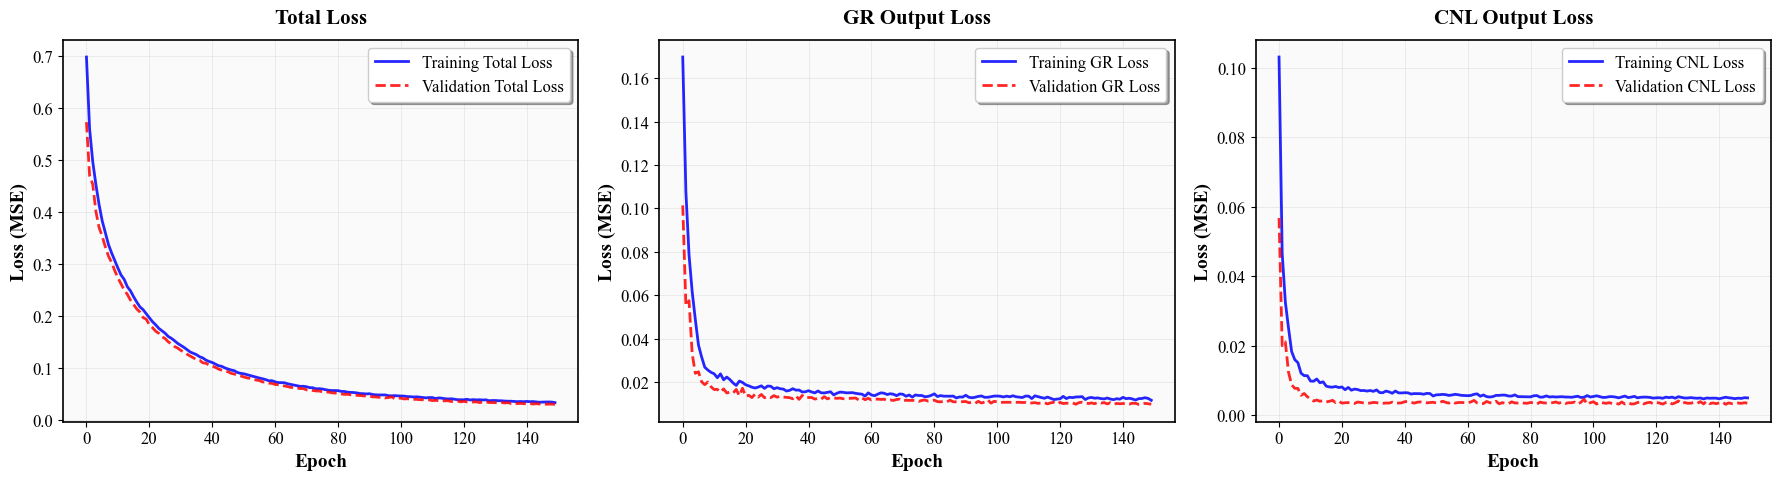

In [25]:
plt.figure(figsize=(18, 5))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 13

# --- 总损失 ---
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'b-', linewidth=2, label='Training Total Loss', alpha=0.85)
plt.plot(history.history['val_loss'], 'r--', linewidth=2, label='Validation Total Loss', alpha=0.85)
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss (MSE)', fontsize=14, fontweight='bold')
plt.title('Total Loss', fontsize=15, fontweight='bold', pad=12)
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.2)
ax.set_facecolor('#fafafa')

# --- GR输出损失 ---
plt.subplot(1, 3, 2)
plt.plot(history.history['gr_output_loss'], 'b-', linewidth=2, label='Training GR Loss', alpha=0.85)
plt.plot(history.history['val_gr_output_loss'], 'r--', linewidth=2, label='Validation GR Loss', alpha=0.85)
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss (MSE)', fontsize=14, fontweight='bold')
plt.title('GR Output Loss', fontsize=15, fontweight='bold', pad=12)
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.2)
ax.set_facecolor('#fafafa')

# --- CNL输出损失 ---
plt.subplot(1, 3, 3)
plt.plot(history.history['cnl_output_loss'], 'b-', linewidth=2, label='Training CNL Loss', alpha=0.85)
plt.plot(history.history['val_cnl_output_loss'], 'r--', linewidth=2, label='Validation CNL Loss', alpha=0.85)
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss (MSE)', fontsize=14, fontweight='bold')
plt.title('CNL Output Loss', fontsize=15, fontweight='bold', pad=12)
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.2)
ax.set_facecolor('#fafafa')

plt.tight_layout()

# 保存为高质量PDF
plt.savefig(r"D:\study\deep\老师中期项目\新思路_新模型1021\多输出损失曲线预测GRCNL_学术版.pdf",
            format="pdf", dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')

plt.show()

In [26]:
# Generate predictions on test data - multi-output
# Make predictions on the test set instead of the entire dataset
predictions = model3.predict(X_test)
gr_predictions = predictions[0]  # GR predictions
cnl_predictions = predictions[1]  # CNL predictions

7/7 [==============================] - 1s 3ms/step


In [27]:
# Get the column names for GR and CNL from the original dataframe
gr_column_name = xie_1.columns[2]  # GR_Z is at index 2
cnl_column_name = xie_1.columns[0]  # CNL_Z is at index 0

# Inverse transform predictions and labels using stored scalers
gr_scaler = scalers[gr_column_name]
cnl_scaler = scalers[cnl_column_name]

# Reshape for inverse transform
gr_predictions_denorm = gr_scaler.inverse_transform(gr_predictions)
gr_actual_denorm = gr_scaler.inverse_transform(y_test_gr.reshape(-1, 1))

cnl_predictions_denorm = cnl_scaler.inverse_transform(cnl_predictions)
cnl_actual_denorm = cnl_scaler.inverse_transform(y_test_cnl.reshape(-1, 1))


GR R² Score (denormalized test data): 0.6259638736762632
CNL R² Score (denormalized test data): 0.8243227609055616


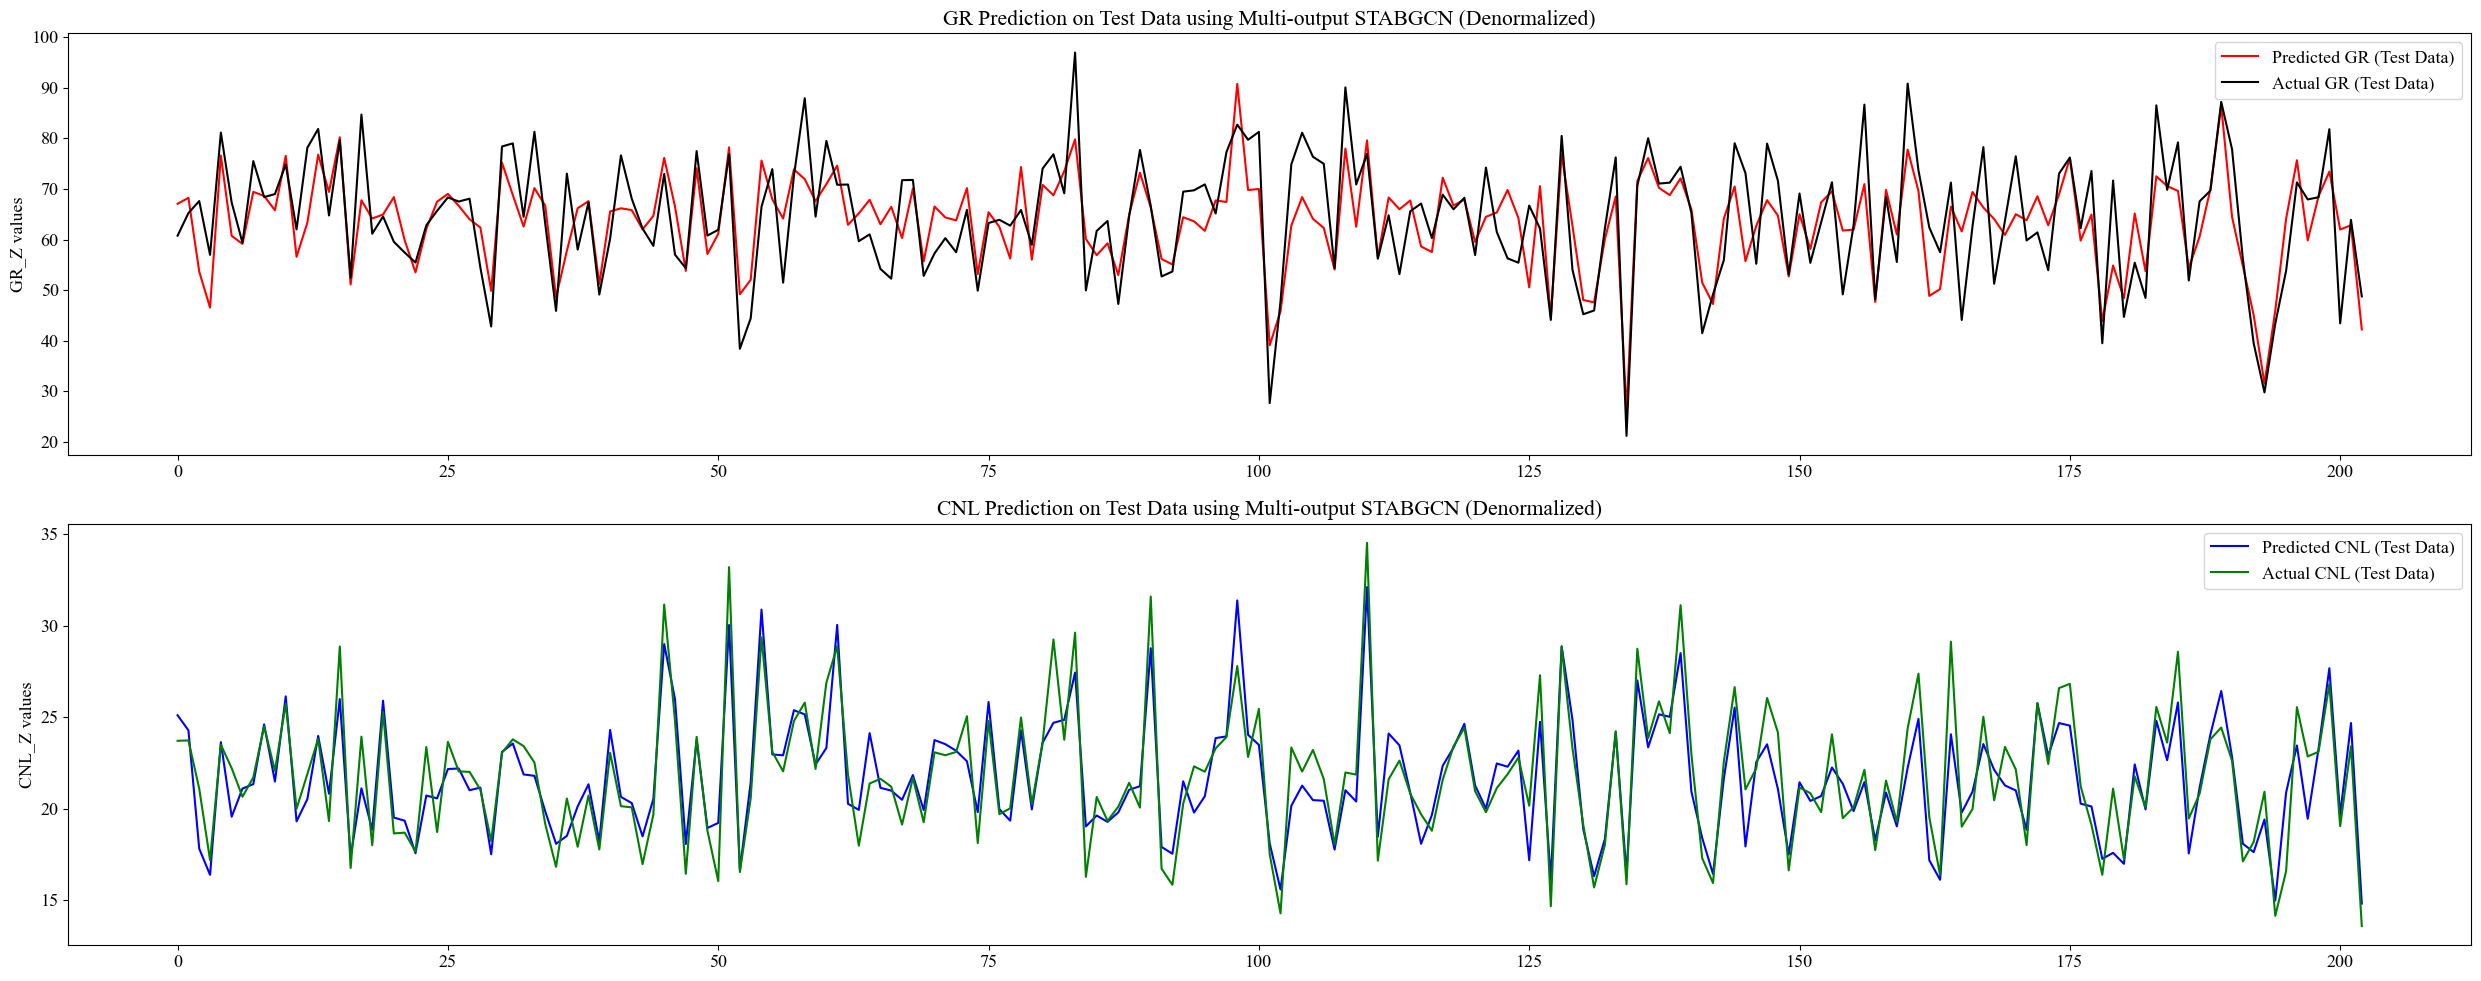

In [28]:

# Calculate R² scores with denormalized test data
r2_gr = r2_score(gr_actual_denorm, gr_predictions_denorm)
print(f'GR R² Score (denormalized test data): {r2_gr}')

r2_cnl = r2_score(cnl_actual_denorm, cnl_predictions_denorm)
print(f'CNL R² Score (denormalized test data): {r2_cnl}')
# Plot - GR prediction results with denormalized test data
plt.figure(figsize=(25, 10))
plt.subplot(2, 1, 1)
plt.plot(gr_predictions_denorm, 'r', label='Predicted GR (Test Data)')
plt.plot(gr_actual_denorm, 'k', label='Actual GR (Test Data)')
plt.title('GR Prediction on Test Data using Multi-output STABGCN (Denormalized)')
plt.legend()
plt.ylabel(f'{gr_column_name} values')

# Plot - CNL prediction results with denormalized test data
plt.subplot(2, 1, 2)
plt.plot(cnl_predictions_denorm, 'b', label='Predicted CNL (Test Data)')
plt.plot(cnl_actual_denorm, 'g', label='Actual CNL (Test Data)')
plt.title('CNL Prediction on Test Data using Multi-output STABGCN (Denormalized)')
plt.legend()
plt.ylabel(f'{cnl_column_name} values')

plt.tight_layout()
plt.show()